Transmission of a linear chain
==============================

In this example we will show the basic features of pynegf by calculating the transmission across an ideal linear chain.
First, we import all the necessary modules.

In [1]:
import numpy
import pynegf
import scipy
#%matplotlib notebook  #Uncomment for inline plots.
import matplotlib.pyplot as plt
from scipy import sparse

Then we define an hamiltonian for our system. We will construct a simple model hamiltonian for a nearest neighbour linear chain. In constructing the hamiltonian we need to follow some strict ordering rules:

- First the hamiltonian of the device region is specified.
- Then the hamiltonian of each contact follows. A contact hamiltonian must consist of 2 principal layers per electrode.

A principal layer is the block-generalized version of a nearest neighbour tight binding site. A well defined principal layers have only non-zero interaction with first-neighbour principal layers. The concept of principal layer is well described in the [dftb manual](https://www.dftbplus.org/fileadmin/DFTBPLUS/public/dftbplus/latest/manual.pdf), a code which utilizes libnegf.

In this example we will construct an hamiltonian with 60 device sites and contacts with 10 sites per principal layer. Note the interaction `[0, 80], [80, 0]`. We need this because the contact specified last is interacting with the first site of the device region. 

In [2]:
def orthogonal_linear_chain(nsites=100, contact_size=20, coupling=1.0):
    mat = numpy.zeros(shape=(nsites, nsites), dtype='complex128')

    for i in range(nsites - contact_size):
        mat[i - 1, i] = coupling
    for i in range(nsites - contact_size, nsites):
        mat[i - 1, i] = coupling
    mat[0, nsites - contact_size] = coupling

    mat_csr = sparse.csr_matrix(mat)
    mat_csr = mat_csr + mat_csr.conjugate(copy=True).transpose()
    mat_csr.sort_indices()

    return mat_csr

mat_csr = orthogonal_linear_chain()

Next, we define an instance of PyNegf, set the hamiltonian and overlap and the relevant PyNegf parameters.
Note that we set an identity overlap with a specific function, but we can set any overlap following the same rules as for the hamiltonian. 
Then we provide structure information with `init_structure`.
In `init_structure` we specify (in fortran indexing):
- The number of contacts
- The index where the contacts end
- The index where the device surface interacting with the contact end (i.e., the beginning of the contact - 1)
- Indices where principal layers of the device region end. If omitted, libnegf will determine automatically a partitioning. This feature is currently only supported for systems with 2 electrodes. 
- The blocks interacting with the contacts. This option can be omitted if `plend` is not specified, as it will not be used. 

In [3]:
negf = pynegf.PyNegf()
negf.set_hamiltonian(mat_csr)
negf.set_identity_overlap(100)
negf.init_structure(
        ncont=2,
        contend=numpy.array([79, 99]),
        surfend=numpy.array([59, 79]),
        plend=None,
        cblk=None)

INFO:root:Running libnegf on 1 processes


After the system is defined, we set general input parameters. In this case it is important to set the real energy axis sampling of the transmission, i.e. the minimum and maximum energy and the step. Indices for Local Density of States are set with the method `set_dos_intervals`. 

Then we can solve the equilibrium Green's function problem by calling `solve_landauer`. 

In [4]:
negf.params.emin = -3.0
negf.params.emax = 3.0
negf.params.estep = 0.01
negf.set_params()
negf.set_ldos_intervals(numpy.array([0, 30, 0]), numpy.array([59, 59, 29]))
negf.solve_landauer()
energies = negf.energies()
trans = negf.transmission()
ldos = negf.ldos()
currents = negf.currents()

The transmission should be a square function, ranging from 2 to +2. The transmission is stored as a 2D ndarray, where each row represent a different electrode pair. for the general N-electrodes case. In this case we only have one pair, therefore one row. 

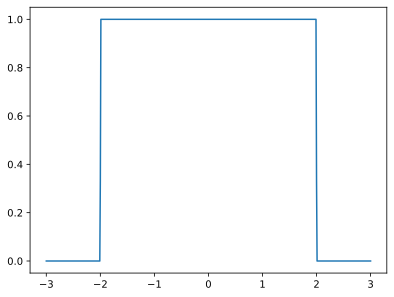

In [5]:
plt.plot(numpy.real(energies), trans[0, :])
plt.show()

The density of states should show 2 Van Hove singularities at -2 and 2

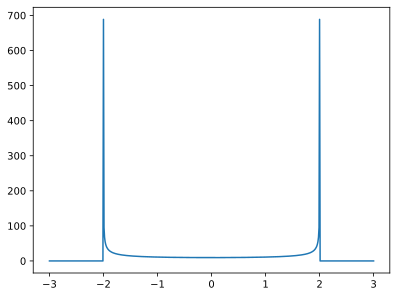

In [6]:
plt.figure()
plt.plot(numpy.real(energies), ldos[0,:])
plt.show()